In [5]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


# selected threshold to highlight yellow lines
yellow_HSV_th_min = np.array([0, 70, 70])
yellow_HSV_th_max = np.array([50, 255, 255])


def thresh_frame_in_HSV(frame, min_values, max_values, verbose=False):
    """
    Threshold a color frame in HSV space
    """
    HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    min_th_ok = np.all(HSV > min_values, axis=2)
    max_th_ok = np.all(HSV < max_values, axis=2)

    out = np.logical_and(min_th_ok, max_th_ok)

    if verbose:
        plt.imshow(out, cmap='gray')
        plt.show()

    return out


def thresh_frame_sobel(frame, kernel_size):
    """
    Apply Sobel edge detection to an input frame, then threshold the result
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)

    _, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)

    return sobel_mag.astype(bool)


def get_binary_from_equalized_grayscale(frame):
    """
    Apply histogram equalization to an input frame, threshold it and return the (binary) result.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eq_global = cv2.equalizeHist(gray)

    _, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

    return th


def binarize(img, verbose=False):
    """
    Convert an input frame to a binary image which highlight as most as possible the lane-lines.
    :param img: input color frame
    :param verbose: if True, show intermediate results
    :return: binarized frame
    """
    h, w = img.shape[:2]

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # highlight yellow lines by threshold in HSV color space
    HSV_yellow_mask = thresh_frame_in_HSV(img, yellow_HSV_th_min, yellow_HSV_th_max, verbose=False)
    binary = np.logical_or(binary, HSV_yellow_mask)

    # highlight white lines by thresholding the equalized frame
    eq_white_mask = get_binary_from_equalized_grayscale(img)
    binary = np.logical_or(binary, eq_white_mask)

    # get Sobel binary mask (thresholded gradients)
    sobel_mask = thresh_frame_sobel(img, kernel_size=9)
    binary = np.logical_or(binary, sobel_mask)

    # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    if verbose:
        f, ax = plt.subplots(2, 3)
        f.set_facecolor('white')
        ax[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[0, 0].set_title('input_frame')
        ax[0, 0].set_axis_off()
#         ax[0, 0].set_axis_bgcolor('red')
        ax[0, 1].imshow(eq_white_mask, cmap='gray')
        ax[0, 1].set_title('white mask')
        ax[0, 1].set_axis_off()

        ax[0, 2].imshow(HSV_yellow_mask, cmap='gray')
        ax[0, 2].set_title('yellow mask')
        ax[0, 2].set_axis_off()

        ax[1, 0].imshow(sobel_mask, cmap='gray')
        ax[1, 0].set_title('sobel mask')
        ax[1, 0].set_axis_off()

        ax[1, 1].imshow(binary, cmap='gray')
        ax[1, 1].set_title('before closure')
        ax[1, 1].set_axis_off()

        ax[1, 2].imshow(closing, cmap='gray')
        ax[1, 2].set_title('after closure')
        ax[1, 2].set_axis_off()
        plt.show()

    return closing

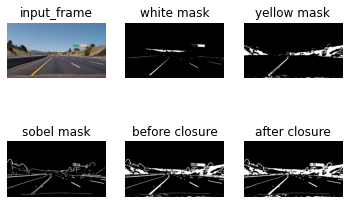

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [6]:
img = cv2.imread(r"../test1.png")

binarize(img, verbose=1)

In [16]:
def birdeye(img, verbose=False):
    """
    Apply perspective transform to input frame to get the bird's eye view.
    :param img: input color frame
    :param verbose: if True, show the transformation result
    :return: warped image, and both forward and backward transformation matrices
    """
    h, w = img.shape[:2]

    src = np.float32([[w, h-10],    # br
                      [0, h-10],    # bl
                      [546, 460],   # tl
                      [732, 460]])  # tr
    dst = np.float32([[w, h],       # br
                      [0, h],       # bl
                      [0, 0],       # tl
                      [w, 0]])      # tr

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    if verbose:
        f, axarray = plt.subplots(1, 2)
        f.set_facecolor('white')
        axarray[0].set_title('Before perspective transform')
        axarray[0].imshow(img, cmap='gray')
        for point in src:
            axarray[0].plot(*point, '.')
        axarray[1].set_title('After perspective transform')
        axarray[1].imshow(warped, cmap='gray')
        for point in dst:
            axarray[1].plot(*point, '.')
        for axis in axarray:
            axis.set_axis_off()
        plt.show()

    return warped, M, Minv

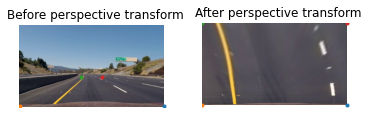

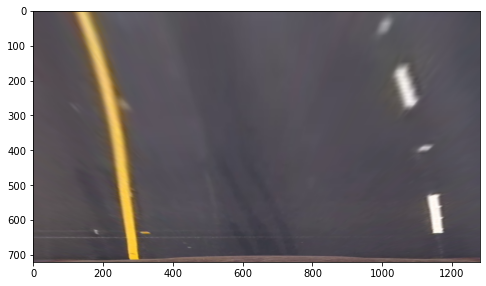

In [17]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath("hong")))))

from calibration import undistort

import pickle
with open('../camera_matrix.pickle', 'rb') as f:
    data = pickle.load(f)
    
mtx = data['mtx']
dist = data['dist']
un_img = undistort(frame=img, mtx=mtx, dist=dist, img_plot=False)
br_img = binarize(un_img, verbose=0)
img_birdeye, M, Minv = birdeye(cv2.cvtColor(un_img, cv2.COLOR_BGR2RGB), verbose=True)

plt.figure(figsize=(8,8))
plt.imshow(img_birdeye)
plt.show()